### 基于LightGBM的LambdaMART排序模型
基本思想：为每个预测时间步都训练一个模型，输入为前段时间的信息，输出为预测时间步的排序信息

训练集和测试集应以时间段来划分

问题在于在这个定义下，我们的训练集和测试集输入的文档都是全新的，而query是旧的。传统的定义是文档是旧的但query是新的

In [11]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import *
import lightgbm as lgb
from tqdm import tqdm

random.seed(42)
np.random.seed(42)

读取数据

In [3]:
# (term_num, time_steps, feature_num)

gene_arr_path = r'../output/gene_editing/result.array'
transplant_arr_path = r'../output/transplant/old_school_decay.array'

gene_name_path = r'../output/gene_editing/ordered_list.list'
transplant_name_path = r'../output/transplant/ordered_list.list'

gene_arr = pickle.load(open(gene_arr_path, mode='rb'))
transplant_arr = pickle.load(open(transplant_arr_path, mode='rb'))

gene_name = pickle.load(open(gene_name_path, mode='rb'))
transplant_name = pickle.load(open(transplant_name_path, mode='rb'))

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

print('Length of the gene_name list:', len(gene_name))
print('Length of the transplant_name list:', len(transplant_name))

Shape of the gene_editing array: (2643, 17, 11)
Shape of the transplant array: (5141, 17, 11)
Length of the gene_name list: 2643
Length of the transplant_name list: 5141


### 截断数据
2019年的数据是收集有误，抛弃2019

In [4]:
gene_arr = gene_arr[:, :-1, :]
transplant_arr = transplant_arr[:, :-1, :]

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 16, 11)
Shape of the transplant array: (5141, 16, 11)


### 规范数据并获取训练集和测试集

In [5]:
scaler, data = scale_data(transplant_arr, 'standard')

def split_data_by_time_ranking(data, scaler):
    # 输入14年的数据，预测1年的
    X_train, y_train, y_train_es = data[:, :14, :], transplant_arr[:, 14, -1].astype(int), transplant_arr[:, 14, -2]
    X_test, y_test, y_test_es = data[:, 1:15, :], transplant_arr[:, 15, -1].astype(int), transplant_arr[:, 15, -2]
    return X_train, X_test, y_train, y_test, y_train_es, y_test_es

In [49]:
X_train, X_test, y_train, y_test, y_train_es, y_test_es = split_data_by_time_ranking(data, scaler)
X_train = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

In [278]:
# 这个方法不行，label最大31
# ordered_train = sorted(range(len(y_train_es)), key=lambda k:y_train_es[k], reverse=True)
# ordered_test = sorted(range(len(y_test_es)), key=lambda k:y_test_es[k], reverse=True)

# for i in range(len(ordered_train)):
#     y_train[ordered_train[i]] = len(ordered_train) - i - 1
#     y_test[ordered_test[i]] = len(ordered_test) - i - 1

### 因为Ranker只接受整数值，所以更具体的相关性没法区分，需要分组对比构造训练集和测试集
效果非常差

In [38]:
# def rank_sampling(X, y, es):
#     result_X = []
#     result_y = []
    
#     _X = X.copy()
#     _y = y.copy()
#     _es = es.copy()
#     score_lookup = list(zip(_X, _y, _es))
    
#     sample_lookup = {}
    
#     for features, label, escore in score_lookup:
#         if label in sample_lookup:
#             sample_lookup[label].append((features, escore))
#         else:
#             sample_lookup[label] = [(features, escore)]
#     i = 0
#     while i < len(score_lookup):
#         candidates = [(score_lookup[i][0], score_lookup[i][2])]
        
#         for label in range(5):
#             idx = np.random.choice(len(sample_lookup[label]), 2)
#             for j in idx:
#                 candidates.append(sample_lookup[label][j])
        
#         candidates = sorted(candidates, key=lambda x: x[1], reverse=True)
#         for k in range(len(candidates)):
#             result_X.append(candidates[k][0])
#             result_y.append(len(candidates) - k)
#         i += 1
#     return np.array(result_X), np.array(result_y)

def pairwise_data(X, y, es):
    result_X = []
    result_y = []
    
    _X = X.copy()
    _y = y.copy()
    _es = es.copy()
    concat_list = list(zip(_X, _y, _es))
    
    for i in tqdm(range(len(concat_list))):
        for j in range(len(concat_list)):
            if i == j:
                continue
            if random.random() > 0.05:
                continue
            
            ix, iy, ies = concat_list[i]
            jx, jy, jes = concat_list[j]
            
            if np.isclose(ies, jes):
                continue
            else:
                result_X.append(ix)
                result_X.append(jx)
                if iy > jy:
                    result_y.append(iy)
                    result_y.append(0)
                elif iy < jy:
                    result_y.append(0)
                    result_y.append(jy)
                else:
                    if ies >= jes:
                        result_y.append(1)
                        result_y.append(0)
                    else:
                        result_y.append(0)
                        result_y.append(1)
    return np.array(result_X), np.array(result_y)

In [39]:
X_train, y_train = pairwise_data(X_train, y_train, y_train_es)
X_test, y_test = pairwise_data(X_test, y_test, y_test_es)

100%|██████████| 5141/5141 [00:37<00:00, 138.24it/s]


In [40]:
X_train.shape, y_train.shape

((2640126, 154), (2640126,))

In [46]:
q_train = [2] * (len(X_train)//2)
q_test = [2] * (len(X_test)//2)
# q_train = [X_train.shape[0]]
# q_test = [X_test.shape[0]]

In [48]:
gbm = lgb.LGBMRanker(class_weight='balanced')
gbm.fit(X_train, y_train, group=q_train, eval_set=[(X_test, y_test)],
eval_group=[q_test], eval_at=[10, 20], early_stopping_rounds=400, verbose=True,
callbacks=[lgb.reset_parameter(learning_rate=lambda x: 0.95 ** x * 0.1)])

[1]	valid_0's ndcg@10: 0.821102	valid_0's ndcg@20: 0.821102
Training until validation scores don't improve for 400 rounds
[2]	valid_0's ndcg@10: 0.823457	valid_0's ndcg@20: 0.823457
[3]	valid_0's ndcg@10: 0.827521	valid_0's ndcg@20: 0.827521
[4]	valid_0's ndcg@10: 0.83048	valid_0's ndcg@20: 0.83048
[5]	valid_0's ndcg@10: 0.831208	valid_0's ndcg@20: 0.831208
[6]	valid_0's ndcg@10: 0.834431	valid_0's ndcg@20: 0.834431
[7]	valid_0's ndcg@10: 0.834715	valid_0's ndcg@20: 0.834715
[8]	valid_0's ndcg@10: 0.826537	valid_0's ndcg@20: 0.826537
[9]	valid_0's ndcg@10: 0.822611	valid_0's ndcg@20: 0.822611
[10]	valid_0's ndcg@10: 0.824399	valid_0's ndcg@20: 0.824399
[11]	valid_0's ndcg@10: 0.822029	valid_0's ndcg@20: 0.822029
[12]	valid_0's ndcg@10: 0.820075	valid_0's ndcg@20: 0.820075
[13]	valid_0's ndcg@10: 0.816842	valid_0's ndcg@20: 0.816842
[14]	valid_0's ndcg@10: 0.816569	valid_0's ndcg@20: 0.816569
[15]	valid_0's ndcg@10: 0.815315	valid_0's ndcg@20: 0.815315
[16]	valid_0's ndcg@10: 0.813992	v

LGBMRanker(boosting_type='gbdt', class_weight='balanced', colsample_bytree=1.0,
           importance_type='split', learning_rate=0.1, max_depth=-1,
           min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
           n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
           random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
           subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [50]:
y_pred = gbm.predict(X_test)

In [51]:
sorted(range(len(y_pred)), key=lambda k:y_pred[k], reverse=True)

[2431,
 4407,
 15,
 742,
 867,
 1812,
 2650,
 4482,
 4703,
 4735,
 4911,
 637,
 4549,
 47,
 97,
 970,
 1553,
 2428,
 2488,
 266,
 2235,
 3764,
 2349,
 1049,
 3686,
 4510,
 4511,
 4454,
 83,
 1342,
 1794,
 2483,
 172,
 1865,
 1014,
 1015,
 5058,
 2381,
 1295,
 139,
 1407,
 2016,
 2332,
 2203,
 118,
 376,
 2917,
 4869,
 1988,
 4543,
 1653,
 110,
 515,
 692,
 1089,
 1393,
 2355,
 2522,
 4956,
 4440,
 4590,
 4901,
 2888,
 4418,
 4715,
 1688,
 2851,
 2496,
 1077,
 3,
 102,
 213,
 265,
 361,
 493,
 512,
 578,
 741,
 772,
 788,
 924,
 948,
 1083,
 1129,
 1135,
 1151,
 1411,
 1664,
 1769,
 1884,
 2294,
 2374,
 2475,
 2657,
 2764,
 2937,
 3287,
 3330,
 3400,
 3732,
 3756,
 3944,
 4121,
 4166,
 4269,
 4428,
 4653,
 4920,
 3095,
 1511,
 758,
 780,
 4414,
 778,
 1440,
 3562,
 2510,
 781,
 42,
 99,
 537,
 547,
 690,
 973,
 1140,
 1923,
 1934,
 3299,
 3539,
 666,
 1870,
 230,
 647,
 934,
 1157,
 1260,
 1355,
 2993,
 3647,
 4017,
 4145,
 4201,
 4957,
 5030,
 5073,
 2042,
 3082,
 1012,
 1480,
 4399,
 

In [52]:
sorted(range(len(y_test)), key=lambda k:y_test[k], reverse=True)

[0,
 9,
 10,
 16,
 21,
 37,
 39,
 83,
 84,
 89,
 99,
 102,
 103,
 110,
 117,
 125,
 150,
 152,
 157,
 169,
 172,
 182,
 183,
 185,
 193,
 194,
 200,
 207,
 219,
 247,
 260,
 265,
 295,
 305,
 312,
 326,
 367,
 376,
 382,
 400,
 417,
 422,
 427,
 428,
 443,
 469,
 470,
 473,
 484,
 503,
 512,
 515,
 525,
 533,
 538,
 542,
 543,
 545,
 558,
 559,
 566,
 610,
 615,
 622,
 632,
 654,
 668,
 682,
 684,
 686,
 692,
 705,
 747,
 758,
 769,
 776,
 778,
 801,
 804,
 807,
 812,
 841,
 844,
 845,
 897,
 933,
 948,
 958,
 970,
 973,
 1003,
 1007,
 1008,
 1012,
 1016,
 1049,
 1089,
 1109,
 1122,
 1136,
 1151,
 1157,
 1159,
 1183,
 1212,
 1219,
 1253,
 1305,
 1350,
 1359,
 1365,
 1382,
 1397,
 1414,
 1438,
 1447,
 1450,
 1468,
 1479,
 1502,
 1545,
 1552,
 1560,
 1622,
 1633,
 1643,
 1680,
 1690,
 1708,
 1718,
 1733,
 1805,
 1810,
 1824,
 1875,
 1891,
 1897,
 1917,
 1919,
 1932,
 1934,
 1977,
 2005,
 2008,
 2027,
 2091,
 2101,
 2160,
 2167,
 2190,
 2227,
 2244,
 2258,
 2261,
 2277,
 2298,
 2310,
 233

In [53]:
y_true = sorted(range(len(transplant_arr)), key=lambda k:transplant_arr[k, -1, -2], reverse=True)
y_true

[1545,
 150,
 1447,
 265,
 3028,
 3587,
 200,
 933,
 1479,
 2957,
 2258,
 193,
 2875,
 4460,
 758,
 1622,
 4199,
 973,
 1212,
 3348,
 812,
 1680,
 4148,
 4322,
 400,
 2008,
 382,
 2628,
 367,
 2915,
 312,
 2310,
 2418,
 3727,
 185,
 484,
 103,
 1382,
 4109,
 1708,
 4453,
 305,
 99,
 897,
 1012,
 4225,
 102,
 1810,
 1450,
 2559,
 2167,
 654,
 804,
 3063,
 3064,
 4529,
 4530,
 2005,
 152,
 2160,
 682,
 686,
 3035,
 668,
 3692,
 538,
 169,
 4399,
 1365,
 4182,
 1414,
 4800,
 1917,
 776,
 844,
 3866,
 4282,
 1438,
 610,
 2944,
 37,
 1350,
 376,
 684,
 2355,
 1502,
 515,
 801,
 9,
 533,
 512,
 769,
 4380,
 443,
 2924,
 470,
 1643,
 1919,
 125,
 2101,
 4454,
 0,
 3065,
 5050,
 3231,
 4606,
 2436,
 219,
 182,
 427,
 2593,
 422,
 4415,
 958,
 2401,
 1359,
 2244,
 260,
 3062,
 326,
 3562,
 417,
 807,
 2556,
 1007,
 1008,
 525,
 615,
 542,
 543,
 469,
 1109,
 2640,
 2027,
 1468,
 2277,
 247,
 1932,
 4235,
 845,
 4499,
 1219,
 4440,
 2381,
 295,
 473,
 3022,
 4747,
 2622,
 3640,
 3446,
 4776,
 62

In [60]:
y_true.index(867)

1992

In [55]:
y_pred[2638]

2.611440213082302

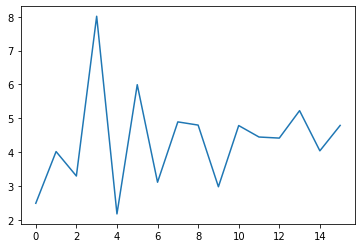

In [18]:
plt.plot(transplant_arr[958, :, -2])

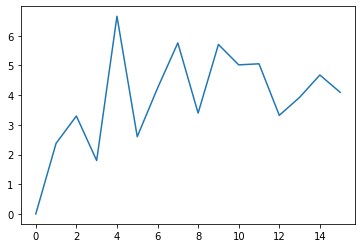

In [285]:
plt.plot(transplant_arr[110, :, -2])

In [155]:
transplant_name[2638]

(2638, 'remote ischemic conditioning')

In [218]:
eval_model('ndcg', np.expand_dims(y_test,axis=1), np.expand_dims(y_pred, axis=1), None)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


(0.8213689751359761, [0.8213689751359761])

In [303]:
yt, yp = eval_model2('classification', np.expand_dims(y_test, axis=1), np.expand_dims(y_pred, axis=1), None)

[[2.]
 [3.]
 [4.]]
[[0.16190206]
 [0.3041031 ]
 [0.43625465]]
259


In [305]:
from sklearn.metrics import classification_report

In [306]:
print(classification_report(yt, yp))

              precision    recall  f1-score   support

           1       0.77      0.78      0.77      3551
           2       0.17      0.20      0.18       663
           3       0.27      0.21      0.24       664
           4       0.29      0.29      0.29       263

    accuracy                           0.60      5141
   macro avg       0.37      0.37      0.37      5141
weighted avg       0.60      0.60      0.60      5141

